In [1]:
# ===== 标准库（Standard Library） =====
import pickle
import random
from time import time
from datetime import datetime
import json

# ===== 科学计算与数据处理（Data Science & Computation） =====
import numpy as np
import pandas as pd
from scipy.stats import zscore
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, silhouette_score, adjusted_rand_score

# ===== 单细胞分析（Single-cell Analysis/Bioinformatics） =====
import anndata as ad
import scanpy as sc
import episcanpy.api as epi

# ===== 深度学习与GNN（Deep Learning & GNN） =====
import torch


# ===== 进度条与实用工具（Progress & Utilities） =====
# scReGAT package imports
from scregat import (
    SCReGAT,
    set_seed,
    train_model,
    test_model,
    get_gene_expression,
    get_edge_info,
    preprocess_graph,
)

/root/anaconda3/envs/scregat/lib/python3.10/site-packages/anndata/_metadata.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
with open(
    "../data/Cortex/External_Hi-C/dataset_atac_add_tf.pkl",
    "rb",
) as f:
    dataset_atac = pickle.load(f)

In [3]:
dataset_atac.list_graph[0]

Data(x=[61528, 1], edge_index=[2, 69180], y=[1], edge_tf=[4036, 2], y_exp=[1348], cell='TCCATACCAATGATGCGGCATTCT')

In [4]:
seed = 42
set_seed(seed)

num_epoch = 4
learning_rate = 1e-4
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")
batch_size = 8

model = SCReGAT()

使用的设备: cuda:3


In [5]:
test_barcode_file = "/remote-home/share/data2/dyn/scReGAT/Cortex/External_Hi-C/test/output_external_4446/test_barcode_epoch4_seed4_seed4446.csv"
test_cell_barcodes = pd.read_csv(test_barcode_file, header=None, index_col=None)
test_cell_barcodes = test_cell_barcodes.loc[:, 0].values
len(test_cell_barcodes)

1065

In [ ]:
test_cell_barcodes

In [6]:
balanced_train_graph, test_graph = preprocess_graph(
    dataset_atac,
    test_cell_barcodes,
    max_random_sample=0,
    seed=seed,
    if_test=False,
    is_balances=False,
)

Preprocess Start!


Processing samples: 100%|██████████| 2130/2130 [00:00<00:00, 9245.30it/s]


train_graph: 1065
test_graph: 1065
random max_values: 5.2995219230651855


Processing samples: 0it [00:00, ?it/s]

adding random nodes...: 0


In [7]:
model = train_model(
    model,
    balanced_train_graph,
    num_epoch=num_epoch,
    batch_size=batch_size,
    lr=learning_rate,
    max_grad_norm=1.0,
    sparse_loss_weight=0.1,
    if_zero=False,
    use_device=device,
)

Epoch 1/4: 100%|██████████| 134/134 [04:26<00:00,  1.99s/batch, loss=1.61, loss1=1.4, sparse_loss=0.208] 


Epoch [1/4], Average Loss: 1.6080, Loss1: 1.4002, Sparse Loss: 0.2078


Epoch 2/4: 100%|██████████| 134/134 [04:49<00:00,  2.16s/batch, loss=0.205, loss1=0.000441, sparse_loss=0.205]


Epoch [2/4], Average Loss: 0.2055, Loss1: 0.0004, Sparse Loss: 0.2050


Epoch 3/4: 100%|██████████| 134/134 [04:25<00:00,  1.98s/batch, loss=0.203, loss1=0.000169, sparse_loss=0.203]


Epoch [3/4], Average Loss: 0.2031, Loss1: 0.0002, Sparse Loss: 0.2029


Epoch 4/4: 100%|██████████| 134/134 [00:17<00:00,  7.53batch/s, loss=0.202, loss1=8.89e-5, sparse_loss=0.202]

Epoch [4/4], Average Loss: 0.2022, Loss1: 0.0001, Sparse Loss: 0.2022


In [8]:
edge_predictions, test_barcodes = test_model(
    dataset_atac, model, test_graph, batch_size=10, device=device, if_test=False
)

Processing Batches: 100%|██████████| 107/107 [00:08<00:00, 12.35it/s]


In [9]:
edge_adata = ad.AnnData(
    X=edge_predictions, obs=dataset_atac.adata.obs.loc[test_barcodes,]
)
edge_adata

AnnData object with n_obs × n_vars = 1065 × 69180
    obs: 'celltype', 'celltype_rna', 'nb_features'

In [10]:
edge_info = get_edge_info(dataset_atac)
edge_info["edge"] = edge_info["peak"] + "_" + edge_info["gene"]
edge_adata.var_names = edge_info.edge.values

In [11]:
def calculate_auc_for_cluster(cluster_id, edge_predictions, edge_indices, edge_adata):
    """
    Calculate AUC for a given cluster using precomputed DE results.

    Parameters:
        cluster_id (str or int): Target cluster identifier.
        edge_predictions (np.ndarray): Feature matrix (cells x features).
        edge_indices (array-like): Indices of selected regulatory edges.
        edge_adata (AnnData): AnnData with edge-level DE results (var_names must match edge_predictions columns).

    Returns:
        float: AUC score.
    """
    # Create binary labels for selected edges
    y_true = np.zeros(edge_predictions.shape[1])
    y_true[edge_indices] = 1

    # Get DE edge names and log fold changes
    edge_names = np.array(edge_adata.uns["rank_genes_groups"]["names"][str(cluster_id)])
    logfc = np.array(
        edge_adata.uns["rank_genes_groups"]["logfoldchanges"][str(cluster_id)]
    )

    # Filter out NaNs
    valid = ~np.isnan(logfc)
    edge_names = edge_names[valid]
    logfc = logfc[valid]

    # Get indices of DE edges that exist in edge_adata.var_names
    valid_idx = edge_adata.var_names.get_indexer(edge_names)
    valid_mask = valid_idx != -1
    gene_indices = valid_idx[valid_mask]
    logfc = logfc[valid_mask]

    if len(gene_indices) == 0:
        return np.nan  # No valid edges

    # Normalize logFC
    logfc = (logfc - logfc.mean()) / logfc.std()

    # True labels for selected DE features
    y_filtered = y_true[gene_indices]

    # Compute AUC
    fpr, tpr, _ = roc_curve(y_filtered, logfc)
    return auc(fpr, tpr)

In [12]:
cell_type_labels = dataset_atac.adata.obs.loc[edge_adata.obs_names]["celltype"].values
cell_type_labels = np.array(cell_type_labels)
cell_type_labels[
    [idx for idx, t in enumerate(cell_type_labels) if t.startswith("excitatory_neuron")]
] = "neuron"
cell_type_labels[
    [idx for idx, t in enumerate(cell_type_labels) if t.startswith("inhibitory_neuron")]
] = "neuron"
unique_cell_types = list(np.unique(cell_type_labels))
unique_cell_types

['astrocyte', 'microglia', 'neuron', 'oligodendrocytes', 'polydendrocytes']

In [13]:
edge_adata.obsm["edge_predictions_zscore"] = zscore(edge_predictions, axis=0)
edge_adata.obs["cluster"] = cell_type_labels.astype(str)

sc.tl.rank_genes_groups(
    edge_adata,
    groupby="cluster",
    reference="rest",
    use_raw=False,
    obsm="edge_predictions_zscore",
    method="wilcoxon",
)

In [14]:
base_path = "/remote-home/share/data2/dyn/scReGAT/Cortex/Base_Hi-C/test/"
cell_types = ["microglia", "neuron", "oligodendrocytes"]
edge_file_paths = [base_path + "base_edge_" + t + ".txt" for t in cell_types]
edge_file_paths

['/remote-home/share/data2/dyn/scReGAT/Cortex/Base_Hi-C/test/base_edge_microglia.txt',
 '/remote-home/share/data2/dyn/scReGAT/Cortex/Base_Hi-C/test/base_edge_neuron.txt',
 '/remote-home/share/data2/dyn/scReGAT/Cortex/Base_Hi-C/test/base_edge_oligodendrocytes.txt']

In [15]:
auc_scores_by_cell_type = []

# Loop over each cell type and its corresponding index
for i, cell_type in enumerate(cell_types):
    # Load the peak-gene edge file for this cell type
    reference_edges = pd.read_csv(
        edge_file_paths[i], header=None, sep="\t", names=["peak", "gene"]
    )

    # Create a unique edge identifier by combining peak and gene
    reference_edges["edge"] = reference_edges["peak"] + "_" + reference_edges["gene"]

    # Find indices of edges present in edge_adata.var_names and remove duplicates
    edge_indices = np.unique(
        np.where(edge_adata.var_names.isin(reference_edges["edge"]))[0]
    )

    # Print the number of edges loaded and how many matched in edge_adata
    print(cell_type, len(reference_edges), len(edge_indices))

    # Calculate AUC score for the current cell type using the identified edge indices
    auc_score = calculate_auc_for_cluster(
        cell_type, edge_predictions, edge_indices, edge_adata
    )

    # Store the result
    auc_scores_by_cell_type.append(auc_score)

microglia 1825 1762
neuron 2703 2577
oligodendrocytes 2604 2440


In [16]:
auc_scores_by_cell_type

[0.740592661313456, 0.6934494785673093, 0.7574418508120512]

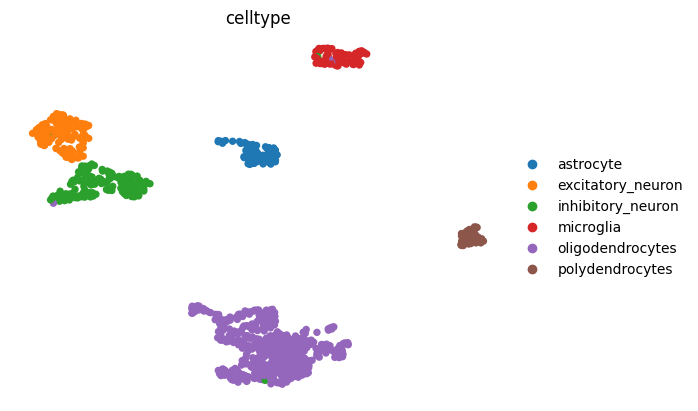

Silhouette Coefficient in PCA space: 0.4650331139564514


In [17]:
edge_adata.X = np.maximum(edge_adata.X, 0)

# Loading the data
adata = edge_adata.copy()  # Assuming this is your RNA-seq data

# Normalize for sequencing depth (total-count normalization)
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize to 10,000 reads per cell

# Log-transformation of the data (common for RNA-seq)
sc.pp.log1p(adata)  # Log-transform the data after normalization

# Identifying highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor="seurat")

# Subset the adata to only highly variable genes
adata = adata[:, adata.var.highly_variable]

# Scaling the data (optional, but often useful for PCA and clustering)
sc.pp.scale(adata, max_value=10)

# Running PCA to reduce dimensions
sc.tl.pca(adata, svd_solver="arpack", n_comps=30)

# Finding neighbors for clustering (based on PCA components)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, metric="cosine")

# Running UMAP for visualization
sc.tl.umap(adata, min_dist=0.5)

# Visualizing the UMAP plot with color based on 'celltype'
sc.pl.umap(adata, color=["celltype"], wspace=0.5, frameon=False)

# Calculate the silhouette score using PCA embeddings
pca_embeddings = adata.obsm["X_pca"]
silhouette_score_value = silhouette_score(
    pca_embeddings, adata.obs["celltype"], metric="cosine"
)

# Printing the silhouette score
print("Silhouette Coefficient in PCA space:", silhouette_score_value)

In [18]:
num_cell_types = len(np.unique(adata.obs.celltype))

Adjusted Rand Index (ARI): 0.7065
真实细胞类型分布:
celltype
oligodendrocytes     539
inhibitory_neuron    165
excitatory_neuron    152
astrocyte             82
microglia             81
polydendrocytes       46
Name: count, dtype: int64

优化后聚类分布:
kmeans_optimized
4    525
2    440
3     73
5     11
1     11
0      5
Name: count, dtype: int64


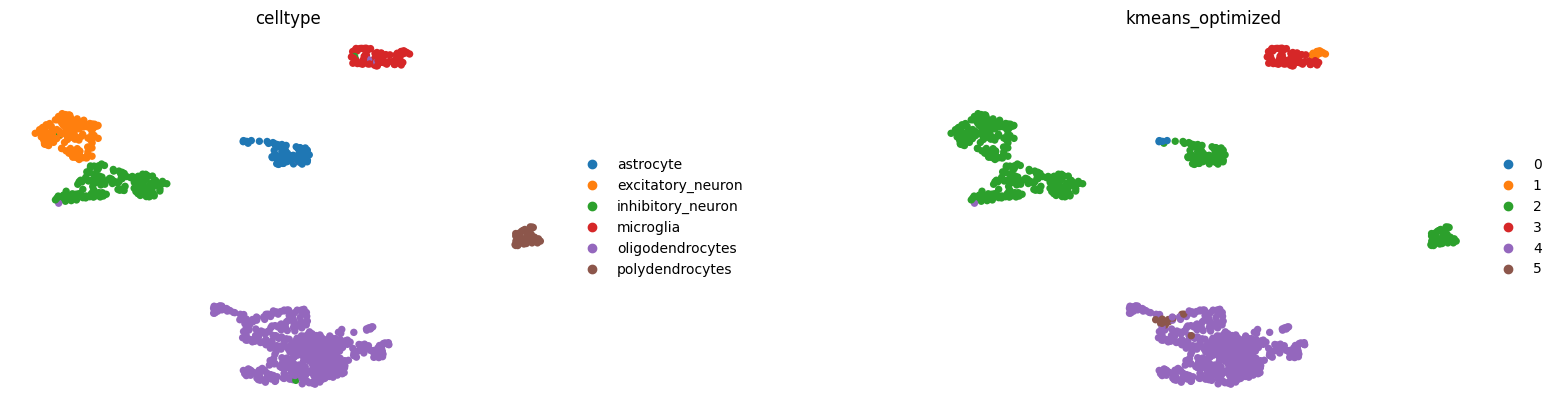

In [19]:
edge_adata.X = np.maximum(edge_adata.X, 0)

# 加载数据
adata = edge_adata.copy()

# 数据预处理
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=10000, flavor="seurat")
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

# 运行PCA降维
sc.tl.pca(adata, svd_solver="arpack", n_comps=30)

# 使用K-means进行聚类，固定类别数
kmeans = KMeans(n_clusters=num_cell_types, random_state=42)
cluster_labels = kmeans.fit_predict(adata.obsm["X_pca"])


# 匈牙利算法匹配标签
def hungarian_algorithm_match(true_labels, pred_labels):
    # 创建混淆矩阵
    true_codes = pd.Categorical(true_labels).codes
    pred_codes = pd.Categorical(pred_labels).codes

    n_true = len(np.unique(true_codes))
    n_pred = len(np.unique(pred_codes))

    # 构建混淆矩阵
    contingency_matrix = np.zeros((n_true, n_pred))
    for i in range(len(true_codes)):
        contingency_matrix[true_codes[i], pred_codes[i]] += 1

    # 使用匈牙利算法找到最优匹配
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # 创建映射字典
    mapping = {pred: true for true, pred in zip(row_ind, col_ind)}

    # 重新映射预测标签
    remapped_labels = np.array([mapping[label] for label in pred_codes])

    return remapped_labels


# 获取真实标签
true_labels = adata.obs["celltype"]

# 用匈牙利算法匹配并重新映射预测标签
optimized_pred_labels = hungarian_algorithm_match(true_labels, cluster_labels)

# 计算ARI
ari_score = adjusted_rand_score(
    pd.Categorical(true_labels).codes, optimized_pred_labels
)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# 可选：将优化后的聚类结果添加到adata中
adata.obs["kmeans_optimized"] = optimized_pred_labels.astype(str)

# 可视化比较
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30, metric="cosine")
sc.tl.umap(adata, min_dist=0.5)

print("真实细胞类型分布:")
print(adata.obs["celltype"].value_counts())
print("\n优化后聚类分布:")
print(adata.obs["kmeans_optimized"].value_counts())

# 可视化
sc.pl.umap(adata, color=["celltype", "kmeans_optimized"], wspace=0.5, frameon=False)

In [20]:
print("ARI:", ari_score)
print("SI score:", silhouette_score_value)
print("celltype:", cell_types)
print("rr_auc:", auc_scores_by_cell_type)
print("mean:", np.mean(auc_scores_by_cell_type))

# # 保存结果到log文件
# # 准备结果数据
# log_data = {
#     "experiment": "Head1",  # 实验名称
#     "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#     "ARI": float(ari_score),
#     "SI_score": float(silhouette_score_value),
#     "celltype": str(cell_types),
#     "rr_auc": [float(x) for x in auc_scores_by_cell_type],
#     "mean_auc": float(np.mean(auc_scores_by_cell_type)),
# }

# # 保存到JSON文件（追加模式）
# log_file = "../output_343206/ablation_results.jsonl"
# with open(log_file, "a", encoding="utf-8") as f:
#     f.write(json.dumps(log_data, ensure_ascii=False) + "\n")

# print("结果已保存到:", log_file)

ARI: 0.7064932464181589
SI score: 0.4650331139564514
celltype: ['microglia', 'neuron', 'oligodendrocytes']
rr_auc: [0.740592661313456, 0.6934494785673093, 0.7574418508120512]
mean: 0.7304946635642722


In [21]:
predicted_gene_expression, test_barcodes, cell_type = get_gene_expression(
    dataset_atac, model, test_graph, batch_size=20, device=device
)
df_predicted_rna = pd.DataFrame(
    predicted_gene_expression,
    index=dataset_atac.adata[test_barcodes].obs_names,
    columns=dataset_atac.array_peak[: len(dataset_atac.df_rna.columns)],
)
df_predicted_rna["celltype"] = dataset_atac.adata[test_barcodes].obs.celltype.values
# 假设 dataset_atac.list_graph 是一个列表，每个元素是一个 Data 对象
cell_barcodes = []
true_expression_values = []

for graph_data in dataset_atac.list_graph:
    cell_barcodes.append(graph_data.cell)  # 提取 cell 名称
    true_expression_values.append(
        graph_data.y_exp.cpu().numpy()
    )  # 提取表达量向量，转为 numpy

# 创建 DataFrame
df_true_rna = pd.DataFrame(true_expression_values, index=cell_barcodes)
df_true_rna.index = dataset_atac.adata[df_true_rna.index,].obs_names
df_true_rna.columns = dataset_atac.array_peak[: len(df_true_rna.columns)]

df_true_rna = df_true_rna.loc[df_predicted_rna.index,]
df_true_rna["celltype"] = dataset_atac.adata[df_true_rna.index].obs.celltype.values
df_true_rna.head()
# path_1 = f"../output_343206/MFG_head1_Pre_exp.csv"
# df_predicted_rna.to_csv(path_1)
# path_2 = f"../output_343206/MFG_head1_True_exp.csv"
# df_true_rna.to_csv(path_2)

Processing Batches: 100%|██████████| 54/54 [00:07<00:00,  7.56it/s]


,VWA1,PRDM16,RBP7,CORT,TNFRSF1B,PDPN,KAZN,PADI2,ALDH4A1,C1QA,...,TMEM255A,TENM1,SASH3,ZDHHC9,AFF2,BGN,PLXNB3,ARHGAP4,GAB3,celltype
TCCATACCAATGATGCGGCATTCT,0.000544,0.000109,0.000361,3.865310e-08,0.000022,0.000058,0.001970,0.001552,0.000019,2.247880e-05,...,0.000052,0.000150,2.755425e-07,0.001915,0.000054,2.643109e-06,0.001346,0.000014,0.000022,oligodendrocytes
ACGCGACGTCTGACGAGCCACAGG,0.000544,0.000109,0.000361,3.865310e-08,0.000022,0.000058,0.001970,0.001552,0.000019,2.247880e-05,...,0.000052,0.000150,2.755425e-07,0.001915,0.000054,2.643109e-06,0.001346,0.000014,0.000022,oligodendrocytes
ATTGAGGAAGTTACGCTCCAACGC,0.000544,0.000109,0.000361,3.865310e-08,0.000022,0.000058,0.001970,0.001552,0.000019,2.247880e-05,...,0.000052,0.000150,2.755425e-07,0.001915,0.000054,2.643109e-06,0.001346,0.000014,0.000022,oligodendrocytes
GGTTAGTTCAATGAGATACTCATA,0.000005,0.000018,0.000006,1.829696e-05,0.000004,0.000043,0.004747,0.000024,0.000019,6.676311e-07,...,0.000004,0.001103,1.303508e-06,0.000199,0.000634,6.948927e-07,0.000006,0.000030,0.000007,excitatory_neuron
ATTGAGGAAGAGGACTGTGAATAT,0.000005,0.000018,0.000006,1.829696e-05,0.000004,0.000043,0.004747,0.000024,0.000019,6.676311e-07,...,0.000004,0.001103,1.303508e-06,0.000199,0.000634,6.948927e-07,0.000006,0.000030,0.000007,excitatory_neuron


In [22]:
df_predicted_rna.head()

,VWA1,PRDM16,RBP7,CORT,TNFRSF1B,PDPN,KAZN,PADI2,ALDH4A1,C1QA,...,TMEM255A,TENM1,SASH3,ZDHHC9,AFF2,BGN,PLXNB3,ARHGAP4,GAB3,celltype
TCCATACCAATGATGCGGCATTCT,0.005788,0.009988,0.006919,0.007853,0.012402,0.010711,0.008596,0.007542,0.007359,0.009484,...,0.005892,0.011780,0.007341,0.006500,0.010646,0.007921,0.006963,0.007661,0.008230,oligodendrocytes
ACGCGACGTCTGACGAGCCACAGG,0.006397,0.006724,0.005807,0.007072,0.010826,0.009499,0.007873,0.007467,0.007683,0.009994,...,0.004903,0.010021,0.008006,0.006023,0.010218,0.007162,0.006236,0.007291,0.006638,oligodendrocytes
ATTGAGGAAGTTACGCTCCAACGC,0.005747,0.008473,0.004845,0.006997,0.012149,0.008166,0.007756,0.007187,0.008504,0.010212,...,0.005861,0.008992,0.009707,0.007332,0.012083,0.007949,0.006679,0.007224,0.008278,oligodendrocytes
GGTTAGTTCAATGAGATACTCATA,0.006841,0.010095,0.009002,0.008774,0.009551,0.004811,0.006873,0.005899,0.008534,0.008183,...,0.008266,0.010234,0.010935,0.008832,0.009836,0.008435,0.007156,0.007501,0.007053,excitatory_neuron
ATTGAGGAAGAGGACTGTGAATAT,0.007954,0.010317,0.009416,0.005167,0.010797,0.007995,0.009009,0.007939,0.008972,0.008211,...,0.007801,0.010968,0.010411,0.010044,0.007539,0.007448,0.007674,0.007556,0.008170,excitatory_neuron
